In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib
import numba

# SPH Approximation In 1D

Defining Kernel

In [2]:
@numba.njit
def gauss(xa, xb, h):
    q = (abs(xa-xb))/h
    scale = 1.0/(h*np.sqrt(np.pi))

    if q<= 3:
        return scale*np.exp(-q**2)
    else:
        return 0

In [3]:
@numba.njit
def cubic_spline(xa, xb, h):
    q = (abs(xa-xb))/h
    
    if q<=1:
        return (2/(3*h))*(1-1.5*(q**2)*(1-q/2))
    if q<=2:
        return (2/(12*h))*((2-q)**3)
    else:
        return 0
    

Kernel Derivatives

In [4]:

def gauss_diff(xa,xb,h):
    xij = xa-xb
    rij = abs(xa-xb)
    q = rij/h
    scale = 1/(h*np.sqrt(np.pi))
    if q <= 3:
        if not xij==0:
            return scale*np.exp(-q**2)*(-2*q/h)*(abs(xij)/xij)
        else: 
            return scale*np.exp(-q**2)*(-2*q/h)
    elif q > 3:
        return 0

In [5]:
def cubic_spline_diff(xa,xb,h):
    xij = xa-xb
    rij = abs(xij)
    q = rij/h
    scale = 2/(3*h)
    if q<=1:
        if not xij ==0 :
            return -1.5*scale*((-(0.5*q**2)/h)+(2*q/h)*(1-0.5*q))*(abs(xij)/xij)
        else :
            return -1.5*scale*((-(0.5*q**2)/h)+(2*q/h)*(1-0.5*q))
    elif q<=2:
        if not xij==0:
            return (-0.75*scale/h*(2-q)**2)*(abs(xij)/xij)
        else:
            return (-0.75*scale/h*(2-q)**2)
    elif q>2:
        return 0


SPH Approximation

In [6]:
def SPH_approx(n,kernel,hdx=1):                                           #Kernel ==1 is Gauss, Kernel==0 Cubic Spline
    xi = np.linspace(-1,1,100)
    dx = 2/n
    h=dx*hdx
    xj = np.linspace(-1+dx,1-dx,n)
    fj = -np.sin(np.pi*xj)
    res = np.zeros(100)
    for i in range(len(xi)):
        for j in range(len(xj)):
            if kernel==1:
                res[i]+=dx*fj[j]*gauss(xi[i], xj[j], h)
            if kernel==0:
                res[i]+=dx*fj[j]*cubic_spline(xi[i], xj[j], h)
                
    return res
    

In [7]:
x = np.linspace(-1,1,100)
SPH_gauss = SPH_approx(25,1)
SPH_cubic_spline = SPH_approx(25,0)


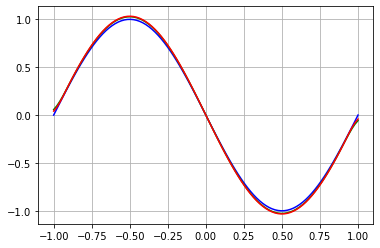

In [8]:
plt.plot(x,-np.sin(np.pi*x),"b")
plt.plot(x,SPH_gauss,"g")
plt.plot(x,SPH_cubic_spline,"r")
plt.grid()

SPH Approximation For Derivatives


In [9]:
def SPH_approx_der(n,kernel):                                           #Kernel==1 is Gauss, Kernel==0 Cubic Spline
    xi = np.linspace(-1,1,100)                                         #I had used fb-fa (not only fb only for case of 1d )
    dx = 2/n
    h=dx
    xj = np.linspace(-1+dx,1-dx,n)
    fj = -np.sin(np.pi*xj)
    res = np.zeros(100)
    for i in range(len(xi)):
        for j in range(len(xj)):
            if kernel==1:
                res[i]+=dx*(fj[j]+np.sin(np.pi*xi[i]))*gauss_diff(xi[i], xj[j], h)
            if kernel==0:
                res[i]+=dx*(fj[j]+np.sin(np.pi*xi[i]))*cubic_spline_diff(xi[i], xj[j], h)
                
    return res
    

In [10]:
x = np.linspace(-1,1,100)
SPH_der_gauss = SPH_approx_der(30,1)
SPH_der_cubic_spline = SPH_approx_der(30,0)


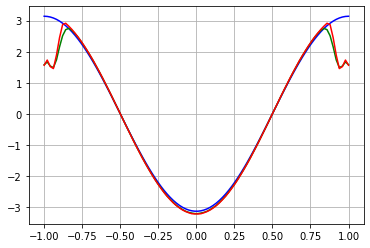

In [11]:
plt.plot(x,-np.pi*np.cos(np.pi*x),"b")
plt.plot(x,SPH_der_gauss,"g")
plt.plot(x,SPH_der_cubic_spline,"r")
plt.grid()

L2 ERROR Calculation

In [12]:
def l2_error(true,evaluate):
    square = (true-evaluate)**2
    total = sum(square)
    return np.sqrt(total/len(true))

1. For Function Approximation

In [13]:
#Variying hdx parameter
x = np.linspace(-1,1,100)
true = -np.sin(np.pi*x)
error_gauss_hdx = []
error_cubic_spline_hdx = []
hdx=np.linspace(0.5,1.5,10)
n=100
for i in range(len(hdx)):
    evaluate_gauss = SPH_approx(n,1,hdx[i])
    evaluate_cubic_spline = SPH_approx(n,0,hdx[i])
    error1 = l2_error(true,evaluate_gauss)
    error2 = l2_error(true,evaluate_cubic_spline)
    error_gauss_hdx.append(error1)
    error_cubic_spline_hdx.append(error2)
        

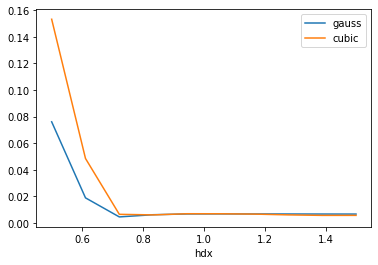

In [14]:
plt.plot(hdx, error_gauss_hdx, label = 'gauss')
plt.plot(hdx,error_cubic_spline_hdx, label = "cubic")
plt.xlabel("hdx")
plt.legend()

In [15]:
#Variying n
x = np.linspace(-1,1,100)
true = -np.sin(np.pi*x)
error_gauss = []
error_cubic_spline = []
number=[]
for n in range(10,100,5):
    evaluate_gauss = SPH_approx(n,1)
    evaluate_cubic_spline = SPH_approx(n,0)
    error1 = l2_error(true,evaluate_gauss)
    error2 = l2_error(true,evaluate_cubic_spline)
    error_gauss.append(error1)
    error_cubic_spline.append(error2)
    number.append(n)    

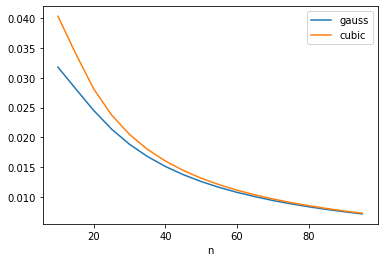

In [16]:
plt.plot(number, error_gauss, label = 'gauss')
plt.plot(number,error_cubic_spline, label = "cubic")
plt.xlabel("n")
plt.legend()

2 For Derivative Approximation

In [17]:
x = np.linspace(-1,1,100)
true_der = -np.pi*np.cos(np.pi*x)
error_gauss_der = []
error_cubic_spline_der = []
number=[]
for n in range(10,100,5):
    evaluate_gauss_der = SPH_approx_der(n,1)
    evaluate_cubic_spline_der = SPH_approx_der(n,0)
    error1_der = l2_error(true_der,evaluate_gauss_der)
    error2_der = l2_error(true_der,evaluate_cubic_spline_der)
    error_gauss_der.append(error1_der)
    error_cubic_spline_der.append(error2_der)
    number.append(n)    

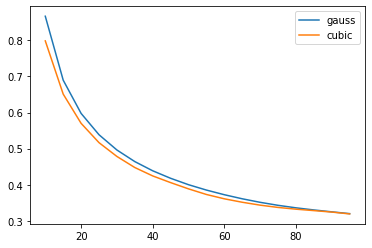

In [18]:
plt.plot(number, error_gauss_der, label = 'gauss')
plt.plot(number,error_cubic_spline_der, label = "cubic")
plt.legend()

Error Of interior Points (exclude points near abs(x)=1)

In [19]:
x = np.linspace(-1,1,100)
true_der = -np.pi*np.cos(np.pi*x)
error_gauss_der_1 = []
error_cubic_spline_der_2 = []
number=[]
for n in range(10,100,5):
    evaluate_gauss_der = SPH_approx_der(n,1)
    evaluate_cubic_spline_der = SPH_approx_der(n,0)
    error1_der = l2_error(true_der[5:-5],evaluate_gauss_der[5:-5])
    error2_der = l2_error(true_der[5:-5],evaluate_cubic_spline_der[5:-5])
    error_gauss_der_1.append(error1_der)
    error_cubic_spline_der_2.append(error2_der)
    number.append(n)    

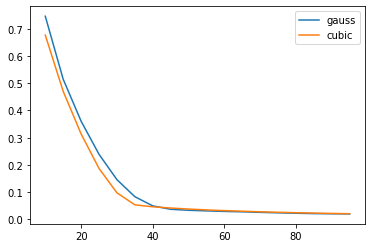

In [20]:
plt.plot(number, error_gauss_der_1, label = 'gauss')
plt.plot(number,error_cubic_spline_der_2, label = "cubic")
plt.legend()

Adding Random Displacement in Positions

For Function Approximation

In [21]:
def density_cal(m,particles,dx):
    rho = np.zeros(len(m))
    for i in range(len(m)):
        density = 0
        for j in range(len(m)):            
            
            density+= gauss(particles[i],particles[j],dx)*m[j]
        rho[i]=density
    return rho

    

In [22]:
#with constant Density
def SPH_approx_noise(n,kernel):                                           #Kernel ==1 is Gauss, Kernel==0 Cubic Spline
    xi = np.linspace(-1,1,100)
    dx = 2/n
    h=dx
    xj = np.linspace(-1+dx,1-dx,n)
    xj_rand = xj + (np.random.random(len(xj))-0.5)*0.01
    fj = -np.sin(np.pi*xj_rand)
    res = np.zeros(100)
    for i in range(len(xi)):
        for j in range(len(xj_rand)):
            if kernel==1:
                res[i]+=dx*fj[j]*gauss(xi[i], xj_rand[j], h)
            if kernel==0:
                res[i]+=dx*fj[j]*cubic_spline(xi[i], xj_rand[j], h)
                
    return res
    

In [23]:
x = np.linspace(-1,1,100)

In [24]:
true_rand = -np.sin(np.pi*x)
error_gauss_rand = []
error_cubic_spline_rand = []
number=[]
for n in range(10,100,5):
    evaluate_gauss_rand = SPH_approx_noise(n,1)
    evaluate_cubic_spline_rand = SPH_approx_noise(n,0)
    error_rand1 = l2_error(true_rand,evaluate_gauss_rand)
    error_rand2 = l2_error(true_rand,evaluate_cubic_spline_rand)
    error_gauss_rand.append(error_rand1)
    error_cubic_spline_rand.append(error_rand2)
    number.append(n)    

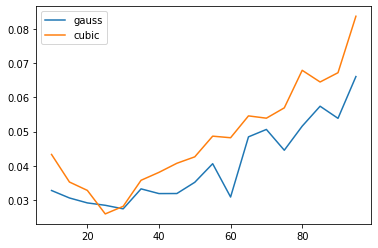

In [25]:
plt.plot(number, error_gauss_rand, label = 'gauss')
plt.plot(number,error_cubic_spline_rand, label = "cubic")
plt.legend()

In [26]:
#with using summation Density
def SPH_approx_noise(n,kernel,delta=0.01):                                           #Kernel ==1 is Gauss, Kernel==0 Cubic Spline
    xi = np.linspace(-1,1,100)
    dx = 2/n
    h=dx
    xj = np.linspace(-1+dx,1-dx,n)
    xj_rand = xj + (np.random.random(len(xj))-0.5)*delta
    fj = -np.sin(np.pi*xj_rand)
    m = np.ones(len(xj))*dx
    rho = density_cal(m, xj_rand,dx)
    res = np.zeros(100)
    for i in range(len(xi)):
        for j in range(len(xj_rand)):
            if kernel==1:
                res[i]+=(m[j]/rho[j])*fj[j]*gauss(xi[i], xj_rand[j], h)
            if kernel==0:
                res[i]+=(m[j]/rho[j])*fj[j]*cubic_spline(xi[i], xj_rand[j], h)
                
    return res
    

In [27]:
true_rand = -np.sin(np.pi*x)
error_gauss_summden = []
number=[]
for n in range(10,100,5):
    evaluate_gauss_rand = SPH_approx_noise(n,1)
    error_rand1 = l2_error(true_rand,evaluate_gauss_rand)
    error_gauss_summden.append(error_rand1)
    number.append(n)    

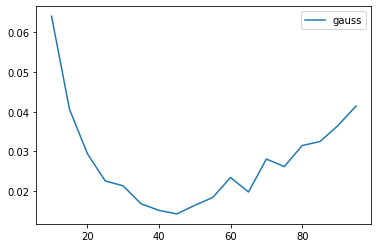

In [28]:
plt.plot(number, error_gauss_summden, label = 'gauss')
plt.legend()

For Derivative Approximation

In [29]:
def SPH_approx_der_noise(n,kernel,delta=0.01):                                           #Kernel==1 is Gauss, Kernel==0 Cubic Spline
    xi = np.linspace(-1,1,100)
    dx = 2/n
    h=dx
    xj = np.linspace(-1+dx,1-dx,n)
    xj_rand = xj + (np.random.random(len(xj))-0.5)*delta
    m = np.ones(len(xj))*dx
    rho = density_cal(m, xj_rand,dx)
    fj = -np.sin(np.pi*xj_rand)
    res = np.zeros(100)
    for i in range(len(xi)):
        for j in range(len(xj_rand)):
            if kernel==1:
                res[i]+=(m[j]/rho[j])*(fj[j]+np.sin(np.pi*xi[i]))*gauss_diff(xi[i], xj_rand[j], h)
#             if kernel==0:
#                 res[i]+=dx*(fj[j]+np.sin(np.pi*xi[i]))*cubic_spline_diff(xi[i], xj_rand[j], h)
                
    return res
    

In [30]:
true_der_rand = -np.pi*np.cos(np.pi*x)
error_gauss_der_sumdensity = []
number=[]
for n in range(10,200,5):
    evaluate_gauss_der_rand = SPH_approx_der_noise(n,1)
    error_rand1 = l2_error(true_der_rand,evaluate_gauss_der_rand)
    error_gauss_der_sumdensity.append(error_rand1)
    number.append(n)    

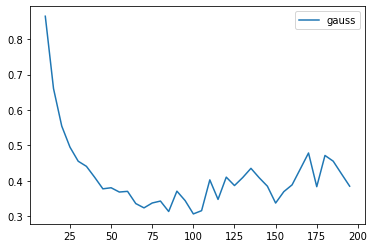

In [31]:
plt.plot(number, error_gauss_der_sumdensity, label = 'gauss')
plt.legend()

# SPH Approximation In 2D

Function Approximation

In [32]:
@numba.njit
def getpoints(n):
    arr = np.zeros((n,n))+1j*np.zeros((n,n))
    arrx = np.linspace(-1,1,n)
    arry = np.linspace(-1,1,n)
    for i in range(len(arrx)):
        for j in range(len(arry)):
            arr[i][j] = arrx[i]+1j*arry[j]
    return arr


In [33]:
@numba.njit
def function_value(arr):
    n=len(arr)
    fun = np.zeros((n,n))
    for i in range(len(arr)):
        for j in range(len(arr)):
            rx = arr[i][j].real
            ry = arr[i][j].imag
            fun[i][j] = np.sin(np.pi*rx)*np.sin(np.pi*ry)
    return fun
    

Gaussian Kernel

In [34]:
@numba.njit
def gauss2d(ra,rb,h):
    q = abs(ra-rb)/h
    scale = 1/(np.pi*h*h)
    if q<= 3:
        #print(scale*np.exp(-q**2))
        return scale*np.exp(-q**2)
    else:
        return 0
    

In [35]:
@numba.njit
def gauss2d_der(ra,rb,h):
    xij = ra-rb
    rij = abs(xij)
    q=rij/h
    scale = 1/(np.pi*h*h)
    dq=0
    if (q < 3.0):
            if (rij > 1e-12):
                dq = (-2.0*scale*q*np.exp(-q*q))/(h*rij)
            
    
    gradx = dq*(xij.real)
    grady = dq*(xij.imag)
    
    return gradx, grady    

SPH approximation Function

In [36]:
@numba.njit
def SPH_approx2d(n,hdx=1):
    dx=2/n
    dy=2/n
    h=dx*hdx
    points = getpoints(100)
    discrete_points= np.zeros((n,n),dtype = np.complex_)
    arrx = np.linspace(-1+dx,1-dx,n)
    arry = np.linspace(-1+dy,1-dy,n)
    for i in range(len(arrx)):
        for j in range(len(arry)):
            discrete_points[i][j] = arrx[i]+1j*arry[j]
    fj = function_value(discrete_points)
    res = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            for k in range(n):
                for l in range(n):
                    ri = points[i][j]
                    rj = discrete_points[k][l]
    
                    res[i][j]+=(dx**2)*(fj[k][l])*gauss2d(ri,rj,h)
    return res
        
    

In [37]:
x=np.linspace(-1,1,100)
y=np.linspace(-1,1,100)
x1,y1 = np.meshgrid(x,y)
real_value = np.sin(np.pi*x1)*np.sin(np.pi*y1)


In [38]:
approximated_value = SPH_approx2d(25)

L2 ERROR

In [39]:
def l2_error_2d(true,approx):
    sqerr=0
    n=len(true)
    for i in range(n):
        for j in range(n):
            sqerr += (approx[i][j]- true[i][j])**2
    return np.sqrt(sqerr/(n**2))
    
    

In [40]:
l2error = l2_error_2d(real_value,approximated_value)
print(l2error)

0.02897864599673005


In [41]:
#l2 error after variying N
x=np.linspace(-1,1,100)
y=np.linspace(-1,1,100)
x1,y1 = np.meshgrid(x,y)
real_value = np.sin(np.pi*x1)*np.sin(np.pi*y1)
l2error2d = []
number=[]
for n in range(10,100,5):
    app_value = SPH_approx2d(n)
    temp_error = l2_error_2d(real_value,app_value)
    l2error2d.append(temp_error)
    number.append(n)


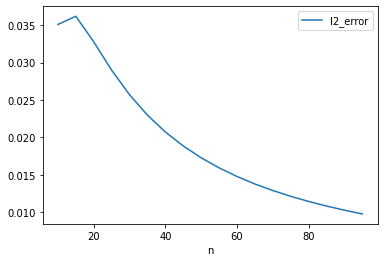

In [42]:
plt.plot(number, l2error2d, label = 'l2_error')
plt.xlabel("n")
plt.legend()

In [43]:
#l2 error after variying hdx parameter
x=np.linspace(-1,1,100)
y=np.linspace(-1,1,100)
x1,y1 = np.meshgrid(x,y)
real_value = np.sin(np.pi*x1)*np.sin(np.pi*y1)
l2error2d_hdx = []
n=100
hdx = np.linspace(0.5,1.5,10)
for i in range(len(hdx)):
    app_value = SPH_approx2d(n,hdx[i])
    temp_error = l2_error_2d(real_value,app_value)
    l2error2d_hdx.append(temp_error)
    


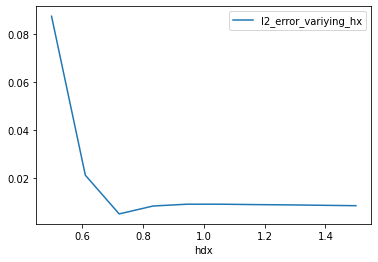

In [44]:
plt.plot(hdx, l2error2d_hdx, label = 'l2_error_variying_hx')
plt.xlabel("hdx")
plt.legend()

Ploting

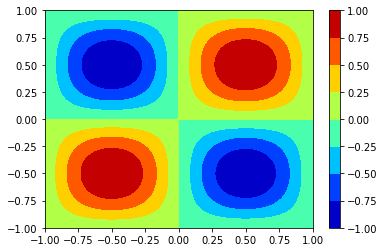

In [45]:
plt.contourf(x1,y1,real_value,cmap = 'jet')
plt.colorbar() 
plt.show() 


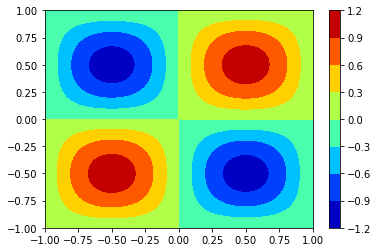

In [46]:
plt.contourf(x1,y1,approximated_value,cmap = 'jet')
plt.colorbar() 
plt.show() 


Derivative Approximation

In [47]:
@numba.njit
def SPH_der_approx2d(n,hdx=1):
    dx=2/n
    dy=2/n
    h=dx*hdx
    points = getpoints(100)
    discrete_points= np.zeros((n,n),dtype = np.complex_)
    arrx = np.linspace(-1+dx,1-dx,n)
    arry = np.linspace(-1+dy,1-dy,n)
    for i in range(len(arrx)):
        for j in range(len(arry)):
            discrete_points[i][j] = arrx[i]+1j*arry[j]
    fj = function_value(discrete_points)
    res_dx = np.zeros((100,100))
    res_dy = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            for k in range(n):
                for l in range(n):
                    ri = points[i][j]
                    rj = discrete_points[k][l]
                    dwx, dwy = gauss2d_der(ri,rj,h)
                    res_dx[i][j] +=(dx**2)*(fj[k][l])*dwx
                    res_dy[i][j] +=(dx**2)*(fj[k][l])*dwy
    return res_dx.T, res_dy.T
        
    

In [48]:
def fun_der(arr):
    n=len(arr)
    funx = np.zeros((n,n))
    funy = np.zeros((n,n))
    for i in range(len(arr)):
        for j in range(len(arr)):
            rx = arr[i][j].real
            ry = arr[i][j].imag
            funx[i][j] = np.pi*np.cos(np.pi*rx)*np.sin(np.pi*ry)
            funy[i][j] = np.pi*np.sin(np.pi*rx)*np.cos(np.pi*ry)
    return funx, funy
    

Visualization With Plots

In [49]:
x=np.linspace(-1,1,100)
y=np.linspace(-1,1,100)
x1,y1 = np.meshgrid(x,y)
exact_dfdx = np.pi*np.cos(np.pi*x1)*np.sin(np.pi*y1)
exact_dfdy = np.pi*np.sin(np.pi*x1)*np.cos(np.pi*y1)



In [50]:
approx_dfdx, approx_dfdy = SPH_der_approx2d(25)


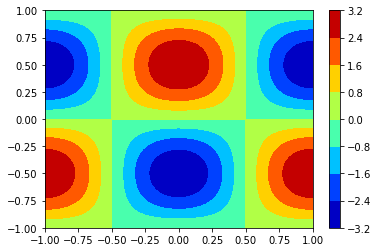

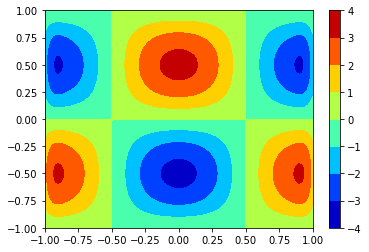

In [51]:
#plot of Exact values of differentiation
plt.contourf(x1,y1,exact_dfdx,cmap = 'jet')
plt.colorbar() 
plt.show() 

#plot of Approximated values of differentiation
plt.contourf(x1,y1,approx_dfdx,cmap = 'jet')
plt.colorbar() 
plt.show() 



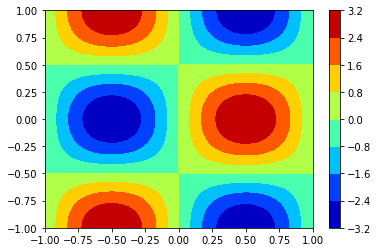

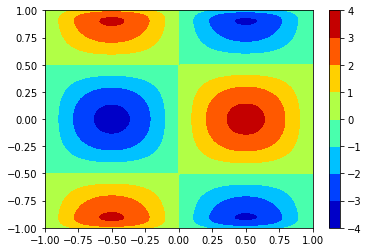

In [52]:
#plot of Exact values of differentiation
plt.contourf(x1,y1,exact_dfdy,cmap = 'jet')
plt.colorbar() 
plt.show() 

#plot of Approximated values of differentiation
plt.contourf(x1,y1,approx_dfdy,cmap = 'jet')
plt.colorbar() 
plt.show() 



l2 error Calculation

In [53]:
#In X direction
l2error_dfx = l2_error_2d(exact_dfdx,approx_dfdx)
print(l2error_dfx)

0.20017126378244274


In [54]:
#In Y direction
l2error_dfx = l2_error_2d(exact_dfdy,approx_dfdy)
print(l2error_dfx)

0.20017126378244254


In [55]:
#l2 error after variying N
x=np.linspace(-1,1,100)
y=np.linspace(-1,1,100)
x1,y1 = np.meshgrid(x,y)
exact_dfdx = np.pi*np.cos(np.pi*x1)*np.sin(np.pi*y1)
exact_dfdy = np.pi*np.sin(np.pi*x1)*np.cos(np.pi*y1)

l2error2d_dfdx = []
l2error2d_dfdy = []

number=[]
for n in range(10,100,5):
    
    app_dfdx, app_dfdy = SPH_der_approx2d(n)
    temp_errordfdx = l2_error_2d(exact_dfdx,app_dfdx)
    temp_errordfdy = l2_error_2d(exact_dfdy,app_dfdy)
    l2error2d_dfdx.append(temp_errordfdx)
    l2error2d_dfdy.append(temp_errordfdy)
    number.append(n)


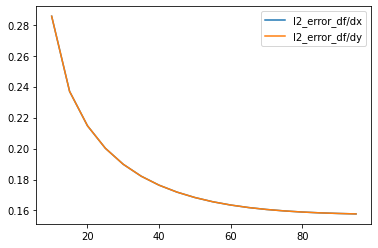

In [56]:
plt.plot(number, l2error2d_dfdx, label = 'l2_error_df/dx')
plt.plot(number, l2error2d_dfdy, label = 'l2_error_df/dy')
plt.legend()

Random Noise added to particles position

In [57]:
@numba.njit
def density_cal_2d(m,particles,dx):
    n=len(m)
    h=dx
    rho = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            density=0
            for k in range(n):
                for l in range(n):
                    ri = particles[i][j]
                    rj = particles[k][l]
                    density += m[i][j]*gauss2d(ri,rj,h)
            rho[i][j]=density
    return rho

    

Function Approximation with adding some random noise to particles

In [58]:
@numba.njit
def SPH_approx_noise2d(n,hdx=1,delta=0.01):
    dx=2/n
    dy=2/n
    h=dx*hdx
    points = getpoints(100)
    discrete_points= np.zeros((n,n),dtype = np.complex_)
    arrx = np.linspace(-1+dx,1-dx,n)
    arrx_rand = arrx + (np.random.random(len(arrx))-0.5)*delta
    arry = np.linspace(-1+dy,1-dy,n)
    arry_rand = arry + (np.random.random(len(arry))-0.5)*delta
    for i in range(len(arrx_rand)):
        for j in range(len(arry_rand)):
            discrete_points[i][j] = arrx_rand[i]+1j*arry_rand[j]
    m = np.ones((n,n))*(dx*dx)
    rho = density_cal_2d(m,discrete_points,dx)
    fj = function_value(discrete_points)
    res = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            for k in range(n):
                for l in range(n):
                    ri = points[i][j]
                    rj = discrete_points[k][l]
    
                    res[i][j]+=(m[k][l]/rho[k][l])*(fj[k][l])*gauss2d(ri,rj,h)
    return res
        
    

In [59]:
#l2 error after variying N
x=np.linspace(-1,1,100)
y=np.linspace(-1,1,100)
x1,y1 = np.meshgrid(x,y)
real_value = np.sin(np.pi*x1)*np.sin(np.pi*y1)
l2error2d_noise = []
number=[]
for n in range(10,100,5):
    app_value_noise = SPH_approx_noise2d(n)
    temp_error = l2_error_2d(real_value,app_value_noise)
    l2error2d_noise.append(temp_error)
    number.append(n)


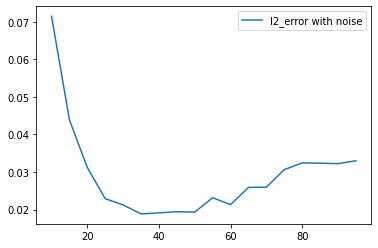

In [60]:
plt.plot(number, l2error2d_noise, label = 'l2_error with noise')
plt.legend()

Derivative of Function Approximation with adding some random noise to particles

In [61]:
@numba.njit
def SPH_approx_der_noise2d(n,hdx=1,delta=0.01):
    dx=2/n
    dy=2/n
    h=dx*hdx
    points = getpoints(100)
    discrete_points= np.zeros((n,n),dtype = np.complex_)
    arrx = np.linspace(-1+dx,1-dx,n)
    arrx_rand = arrx + (np.random.random(len(arrx))-0.5)*delta
    arry = np.linspace(-1+dy,1-dy,n)
    arry_rand = arry + (np.random.random(len(arry))-0.5)*delta
    for i in range(len(arrx_rand)):
        for j in range(len(arry_rand)):
            discrete_points[i][j] = arrx_rand[i]+1j*arry_rand[j]
    m = np.ones((n,n))*(dx*dx)
    rho = density_cal_2d(m,discrete_points,dx)
    fj = function_value(discrete_points)
    res_dx = np.zeros((100,100))
    res_dy = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            for k in range(n):
                for l in range(n):
                    ri = points[i][j]
                    rj = discrete_points[k][l]
                    dwx, dwy = gauss2d_der(ri,rj,h)
                    res_dx[i][j]+=(m[k][l]/rho[k][l])*(fj[k][l])*dwx
                    res_dy[i][j]+=(m[k][l]/rho[k][l])*(fj[k][l])*dwy
    return res_dx.T, res_dy.T
        
    

In [62]:
#l2 error after variying N
x=np.linspace(-1,1,100)
y=np.linspace(-1,1,100)
x1,y1 = np.meshgrid(x,y)
exact_dfdx = np.pi*np.cos(np.pi*x1)*np.sin(np.pi*y1)
exact_dfdy = np.pi*np.sin(np.pi*x1)*np.cos(np.pi*y1)

l2error2d_dfdx_noise = []
l2error2d_dfdy_noise = []

number=[]
for n in range(10,100,5):
    
    app_dfdx_noise, app_dfdy_noise = SPH_approx_der_noise2d(n)
    temp_errordfdx = l2_error_2d(exact_dfdx,app_dfdx_noise)
    temp_errordfdy = l2_error_2d(exact_dfdy,app_dfdy_noise)
    l2error2d_dfdx_noise.append(temp_errordfdx)
    l2error2d_dfdy_noise.append(temp_errordfdy)
    number.append(n)


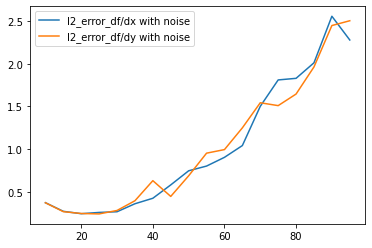

In [63]:
plt.plot(number, l2error2d_dfdx_noise, label = 'l2_error_df/dx with noise')
plt.plot(number, l2error2d_dfdy_noise, label = 'l2_error_df/dy with noise')
plt.legend()

Ploting (case of added noise)

In [64]:
approx_dfdx, approx_dfdy = SPH_approx_der_noise2d(20)


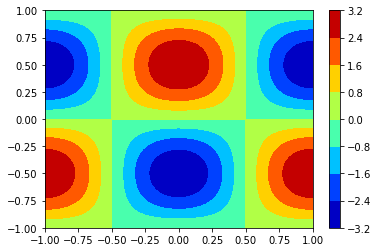

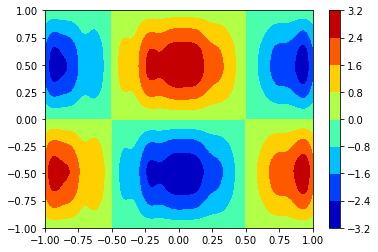

In [65]:
#plot of Exact values of differentiation
plt.contourf(x1,y1,exact_dfdx,cmap = 'jet')
plt.colorbar() 
plt.show() 

#plot of Approximated values of differentiation
plt.contourf(x1,y1,approx_dfdx,cmap = 'jet')
plt.colorbar() 
plt.show() 



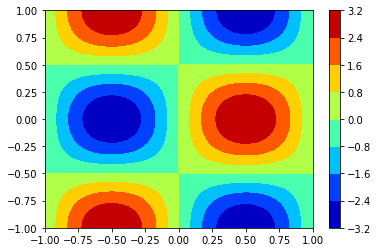

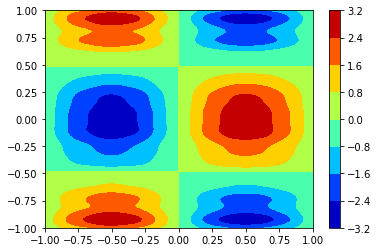

In [66]:
#plot of Exact values of differentiation
plt.contourf(x1,y1,exact_dfdy,cmap = 'jet')
plt.colorbar() 
plt.show() 

#plot of Approximated values of differentiation
plt.contourf(x1,y1,approx_dfdy,cmap = 'jet')
plt.colorbar() 
plt.show() 

